# Error for GLV dynamics

Define errors in $x$ and $\beta$ direction:

> $\mathrm{err}_x = 1 - \frac{x(\beta_\mathrm{eff})}{x_\mathrm{eff}}$

> $\mathrm{err}_\beta = 1 - \frac{\beta(x_\mathrm{eff})}{\beta_\mathrm{eff}}$

For the GLV, the coincide:

> $x(\beta_\mathrm{eff}) = - \frac{\alpha}{\beta_\mathrm{eff}}$, 

such that 

> $ \mathrm{err} = 1 + \frac{\alpha}{x_\mathrm{eff} \beta_\mathrm{eff}}$ .

Inserting the definitions of $x_\mathrm{eff}$ and $\beta_\mathrm{eff}$ from Gao et al.'s paper, 

> $ x_\mathrm{eff} = \frac{\sum_{ij} A_{ij} x_j}{\sum_{mn} A_{mn}}  $, 

> $ \beta_\mathrm{eff} = \frac{\sum_{ijk} A_{ij} A_{jk} }{\sum_{mn} A_{mn}} $, 

we get 

> $
    \mathrm{err} = 1 + \frac{
        \alpha \left(\sum_{mn} A_{mn}\right) \left(\sum_{mn} A_{mn}\right) 
        }{
        - \alpha \left( \sum_{ijk} A_{ij} {A^{-1}}_{jk} \right) \left(\sum_{ijk} A_{ij} A_{jk}\right) 
        }
        = 1 - \frac{\sum_{ijkl} A_{ij} A_{kl} }{ S \sum_{ijk} A_{ij} A_{jk} }
$


Now, if all entries are drawn independently from one distribution, $A_{ij} \sim p(\mu, \sigma^2)$,
one can calculate the expected value 

> $\mathbb{E}\left[ \mathrm{err} \right] 
    = 1 - \mathbb{E} \left[\frac{\sum_{ijkl} A_{ij} A_{kl} }{ S \sum_{ijk} A_{ij} A_{jk} }\right]   $ .
    
This cannot be calculated directly. If, however, we assume the denominator ot be much larger than zero, we might be able to approximate by taking the expected values separately -- this is what we shall test numerically. However, doing this separation yields

> $ \mathbb{E} \left[ \sum_{ijkl} A_{ij} A_{kl} \right]
    = \mathbb{E} \left[
    \sum_{(i, j) \ne (k, l)} A_{ij} A_{jk} + \sum_{(i, j)} A_{ij}^2 \right]
    = (S^4  - S^2) \mu^2 + S^2(\sigma^2 + \mu^2)
    = S^2(S^2 \mu^2 + \sigma^2)
$

and

> $ \mathbb{E} \left[ \sum_{ijk} A_{ij} A_{jk} \right] 
    = \mathbb{E} \left[\sum_{j, i \ne k} A_{ij} A_{jk} + \sum_{j \ne i} A_{ij} A_{ji} + \sum_{i} A_{ii}^2 \right]
    = S^2 (S - 1) \mu^2 + S (S - 1) \mu^2 + S (\sigma^2 + \mu ^ 2) 
    = S(S^2 \mu^2 + \sigma^2) $

which gives 

> $ 1 - \frac{ \mathbb{E} \left[ \sum_{ijkl} A_{ij} A_{kl} \right]} 
{S \mathbb{E} \left[ \sum_{ijk} A_{ij} A_{jk} \right]}
= 1 - \frac{S^2(S^2 \mu^2 + \sigma^2)}{S^2 (S^2 \mu^2 + \sigma^2)} = 0 $.

So, either this approximation does not hold or higher order terms are important.

Note that the variance 

> $\mathbb{E}[err^2] \approx \frac{\mathbb{E}[n^2 - 2nd + d^2]}{\mathbb{E}[d^2]} =
\frac{\left(S^3 - S^2 - 3S + 3 \right) \sigma^4 + (S - 1) \mu_4}{S^6 \mu^4 + 6 S^4 \sigma^2 \mu^2 + \left(S^3 + 2S^2 - 3S\right) \sigma^4 + 4 S^2 \mu_3 \mu + S \mu_4} 
\sim \frac{1}{S^3 \left(\frac{\mu}{\sigma}\right)^4}$ 

is computed in a separate notebook. 


## Import and define stuff

In [4]:
from __future__ import print_function
import numpy as np

% matplotlib inline 
import matplotlib.pyplot as plt
from imp import reload
import style as style; reload(style)
colors = style.colors

def results(errs, Ss, mu, sigma, mu_3, mu_4):
    # Calculate measured and empirical means
    means, stds = np.mean(errs, axis=1), np.std(errs, axis=1)

    mean_theo   = lambda S: 0. * S
    std_theo    = lambda S:  np.sqrt(1. / (S**3 * (mu / sigma)**4))
    std_theo_full = lambda S:  np.sqrt((
            (S**3 - S**2 - 3*S + 3) * sigma**4 + (S - 1) * mu_4) / (
            S**6 * mu**4 + 6 * S**4 * sigma**2 * mu**2 + (S**3 + 2 * S**2 - 3 * S) * sigma**4 + 4 * S**2 * mu_3 * mu + S * mu_4))

    print("mean(err)_measured   std(err)_theo  std(err)_measured")
    for mean, S , std in zip(means, Ss, stds):
        if mean < 0:
            print("%.6f            %.6f       %.6f"%(mean, std_theo_full(S), std))
        else:
            print(" %.6f            %.6f       %.6f"%(mean, std_theo_full(S), std))


    # Plotting
    fig = plt.figure(figsize=(15, 9))
    ax = style.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

    for k, S in enumerate(Ss):
        ax.plot([S]*n_samples, errs[k], '.', color=colors[0])

    # Empirical means and std devs
    ax.plot(Ss, means, 'o', color=colors[1], label=r"$\mu_\mathrm{measured}$")
    ax.plot(Ss, means + stds, 'o', color=colors[2], label=r"$\sigma_\mathrm{measured}$")
    ax.plot(Ss, means - stds, 'o', color=colors[2])

    # Theoretical means and std devs
    S_c = np.linspace(10, max(Ss) + 10, 200)
    ax.plot(S_c, mean_theo(S_c), '-', color=colors[2], label=r"$\mu_\mathrm{theo} = 0.$")
    # # Asymptotic std dev
    # ax.plot(S_c, mean_theo(S_c) + std_theo(S_c), '--', color=colors[2], label=r"$\sigma_\mathrm{theo}$")
    # ax.plot(S_c, mean_theo(S_c) - std_theo(S_c), '--', color=colors[2])
    # ax.fill_between(S_c, mean_theo(S_c) + std_theo(S_c), mean_theo(S_c) - std_theo(S_c), color=colors[2], alpha=0.2)
    # Exact std dev
    ax.plot(S_c, mean_theo(S_c) + std_theo_full(S_c), '--', color=colors[2], label=r"$\sigma_\mathrm{theo}$")
    ax.plot(S_c, mean_theo(S_c) - std_theo_full(S_c), '--', color=colors[2])
    ax.fill_between(S_c, mean_theo(S_c) + std_theo_full(S_c), mean_theo(S_c) - std_theo_full(S_c), color=colors[2], alpha=0.2)

    ax.set_xlabel("$S$")
    ax.set_ylabel("$err$")
    ax.set_xlim(0, S_max + 10)
    ax.legend(loc='best')
    style.fixticks(fig)

## Test results numerically for $A_{ij} > 0 \sim$ log-normal, iid

The log-normal distribution has the following moments:

> $ \mu_l      = e^{\mu +\sigma ^{2}/2} $ 
 
> $ \sigma_l^2 = (e^{\sigma ^{2}}\!\!-1)e^{2\mu +\sigma ^{2}} $

> $ \mu_{l, 3} = (e^{\sigma ^{2}}\!\!+2){\sqrt {e^{\sigma ^{2}}\!\!-1}} \cdot \sigma_l^3 $

> $ \mu_{l, 4} = (e^{4\sigma ^{2}}\!\!+2e^{3\sigma ^{2}}\!\!+3e^{2\sigma ^{2}}\!\!-3) \cdot \sigma_l^4 $

where $\mu$ and $\sigma$ are the mean and variance of the underlying normal distribution.


Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80
Calculate error for S = 90
Calculate error for S = 100
Calculate error for S = 110
Calculate error for S = 120
mean(err)_measured   std(err)_theo  std(err)_measured
-0.000765            0.019211       0.018378
-0.000407            0.010457       0.009712
-0.000045            0.006792       0.007001
-0.000335            0.004860       0.004961
 0.000213            0.003697       0.003720
 0.000113            0.002934       0.002974
 0.000011            0.002401       0.002351
-0.000083            0.002012       0.002031
-0.000140            0.001718       0.001689
-0.000009            0.001489       0.001460
 0.000022            0.001307       0.001339


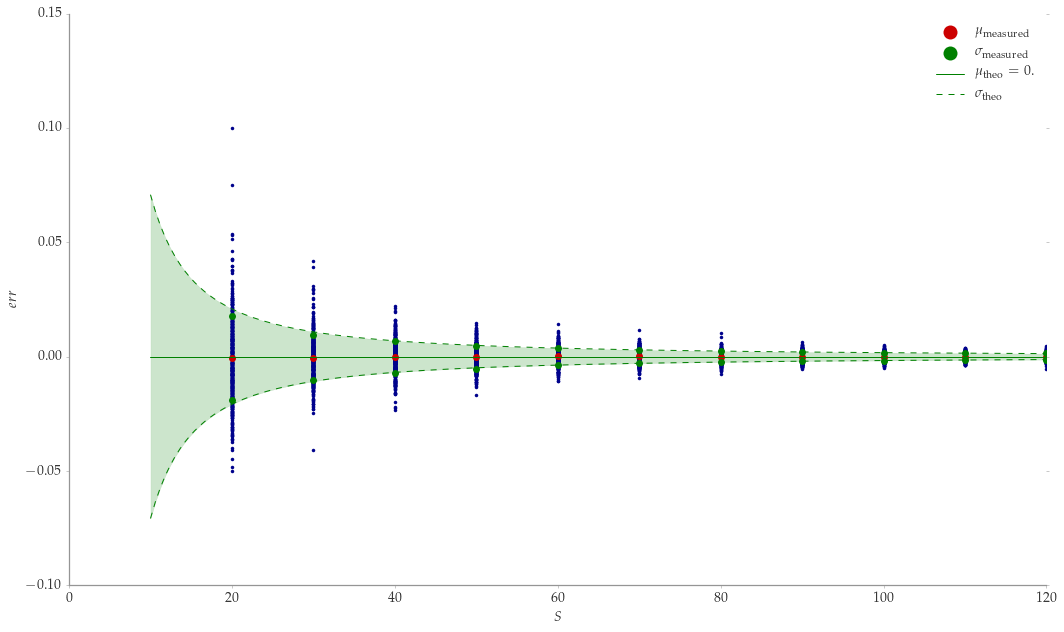

In [5]:
# Choose network sizes to be sampled from
S_min = 20
S_max = 120
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 500

# Mean and variance of underlying gaussian
mu_normal       = 0.
sigma_normal    = 1.

# Moments of actual distribution
mu      = np.exp(mu_normal + sigma_normal**2 / 2.)
sigma   = np.sqrt((np.exp(sigma_normal**2) - 1.) * np.exp(2 * mu_normal + sigma_normal**2))
mu_3    = (np.exp(sigma_normal**2) + 2) * np.sqrt(np.exp(sigma_normal**2) - 1.) * sigma**3
mu_4    = (np.exp(4 * sigma_normal**2) + 2 * np.exp(3 * sigma_normal**2) + 3 * np.exp(2 * sigma_normal**2) - 3) * sigma**4

# Sample and calculate error
errs = np.zeros((len(Ss), n_samples)) 
for k, S in enumerate(Ss):
    print("Calculate error for S = %d"%S)
    for i in range(n_samples):
        # Sample A
        A = np.random.lognormal(mean=mu_normal, sigma=sigma_normal, size=(S, S))

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[k, i] = 1. - num / den
        
results(errs, Ss, mu, sigma, mu_3, mu_4)

## Non-zero mean but possibly negative random variables

Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80
Calculate error for S = 90
Calculate error for S = 100
Calculate error for S = 110
Calculate error for S = 120
mean(err)_measured   std(err)_theo  std(err)_measured
-0.000411            0.011180       0.010463
 0.000205            0.006086       0.006248
 0.000029            0.003953       0.003902
 0.000036            0.002828       0.002929
-0.000057            0.002152       0.002234
-0.000012            0.001707       0.001700
 0.000001            0.001398       0.001384
 0.000027            0.001171       0.001194
-0.000003            0.001000       0.000982
 0.000057            0.000867       0.000853
 0.000021            0.000761       0.000723


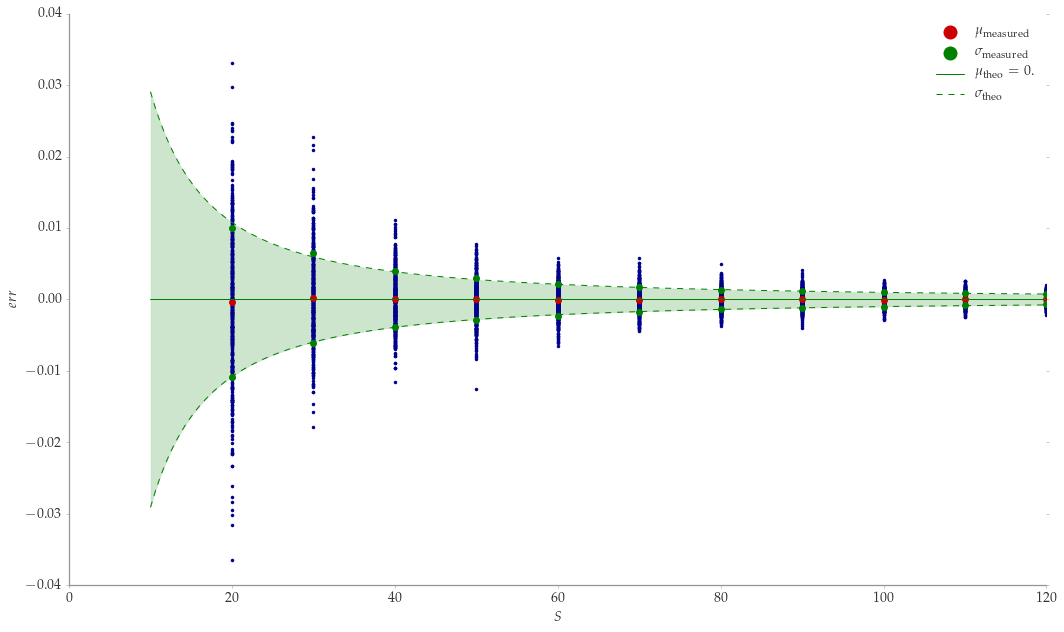

In [6]:
# Choose network sizes to be sampled from
S_min = 20
S_max = 120
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 500

# Moments of distribution
mu      = 1.
sigma   = 1.
mu_3    = 0. * sigma**3
mu_4    = 3. * sigma**4

# Sample and calculate error
errs = np.zeros((len(Ss), n_samples)) 
for k, S in enumerate(Ss):
    print("Calculate error for S = %d"%S)
    for i in range(n_samples):
        # Sample A
        A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[k, i] = 1. - num / den
        
results(errs, Ss, mu, sigma, mu_3, mu_4)

## Worst case scenario: zero mean 

Calculate error for S = 20
Calculate error for S = 30
Calculate error for S = 40
Calculate error for S = 50
Calculate error for S = 60
Calculate error for S = 70
Calculate error for S = 80
Calculate error for S = 90
Calculate error for S = 100
Calculate error for S = 110
Calculate error for S = 120
mean(err)_measured   std(err)_theo  std(err)_measured
 1.173070            inf       7.817059
 1.394177            inf       9.258264
 0.946472            inf       1.777211
 1.030760            inf       1.145310
 0.933299            inf       1.409448
 1.056755            inf       2.375900
 1.144851            inf       6.177349
 2.174133            inf       25.995233
 0.671641            inf       6.411922
 0.504611            inf       14.104301
 0.816365            inf       2.951436


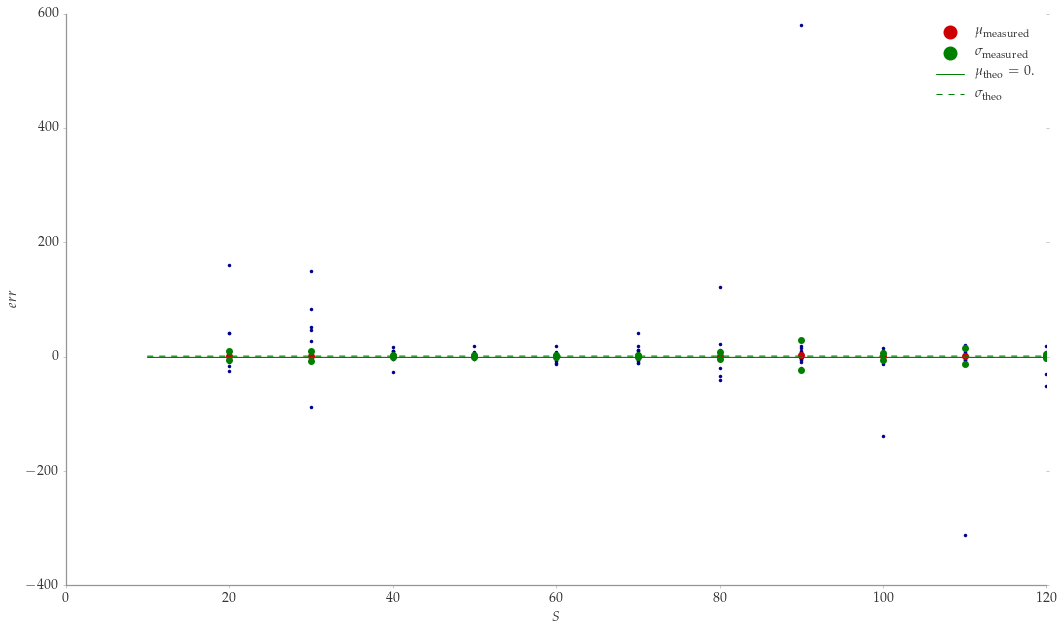

In [7]:
# Choose network sizes to be sampled from
S_min = 20
S_max = 120
S_step = 10
Ss = np.arange(S_min, S_max + S_step, S_step)

# Number of samples
n_samples = 500

# Moments of distribution
mu      = 0.
sigma   = 1.
mu_3    = 0. * sigma**3
mu_4    = 3. * sigma**4

# Sample and calculate error
errs = np.zeros((len(Ss), n_samples)) 
for k, S in enumerate(Ss):
    print("Calculate error for S = %d"%S)
    for i in range(n_samples):
        # Sample A
        A = np.random.normal(loc=mu, scale=sigma, size=(S, S))

        # Calculate err
        num = np.einsum('ij, kl ->', A, A)
        den = S * np.einsum('ij, jk -> ', A, A)
        errs[k, i] = 1. - num / den
        
results(errs, Ss, mu, sigma, mu_3, mu_4)